In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr

# --- КОНФІГУРАЦІЯ ---
%matplotlib inline
save_figures = False
os.makedirs("plots", exist_ok=True)

--- Завантаження даних ---

In [2]:
df = pd.read_csv("C:/Users/Dasha Koshykova/PycharmProjects/pythonProject5/lab2/data/train.csv")  

--- Огляд даних ---

In [3]:
print(df.head())
print(df.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
Pa

--- Обробка пропущених значень ---

In [4]:
df_filled = df.copy()
df_filled["Age"] = df_filled["Age"].fillna(df_filled["Age"].median())
df_filled["Embarked"] = df_filled["Embarked"].fillna(df_filled["Embarked"].mode()[0])
df_filled["Cabin"] = df_filled["Cabin"].fillna("Unknown")

--- Нормалізація і стандартизація ---

In [5]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

def standardize(arr):
    return (arr - np.mean(arr)) / np.std(arr)

age_array = df_filled["Age"].values
age_normalized = normalize(age_array)
age_standardized = standardize(age_array)


--- Гістограма віку ---

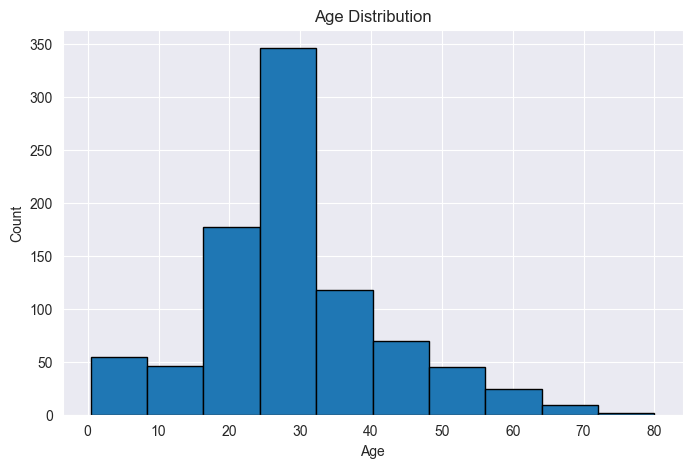

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(df_filled["Age"], bins=10, edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.grid(True)
if save_figures:
    plt.savefig("plots/age_histogram.png")
plt.show()

--- Графік залежності Fare від Age ---

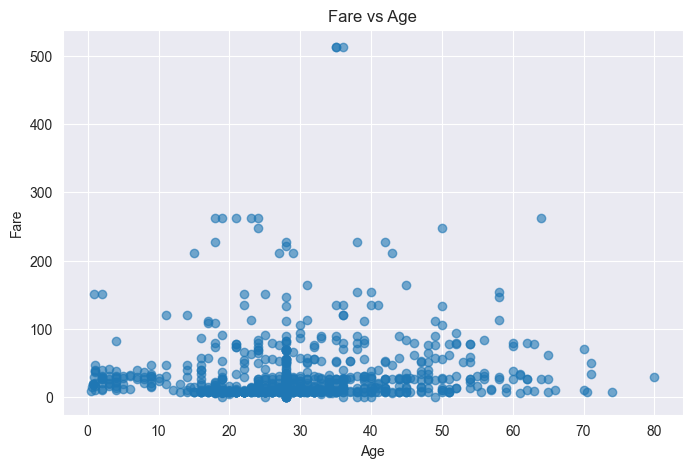

In [7]:
plt.figure(figsize=(8, 5))
plt.scatter(df_filled["Age"], df_filled["Fare"], alpha=0.6)
plt.title("Fare vs Age")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.grid(True)
if save_figures:
    plt.savefig("plots/fare_vs_age.png")
plt.show()

--- Коефіцієнти кореляції ---

In [8]:
pearson_corr, _ = pearsonr(df_filled["Age"], df_filled["Fare"])
spearman_corr, _ = spearmanr(df_filled["Age"], df_filled["Fare"])
print(f"Pearson: {pearson_corr:.3f}")
print(f"Spearman: {spearman_corr:.3f}")

Pearson: 0.097
Spearman: 0.126


--- One Hot Encoding ---

In [9]:
encoder = OneHotEncoder(sparse_output=False)
embarked_encoded = encoder.fit_transform(df_filled[["Embarked"]])
embarked_df = pd.DataFrame(embarked_encoded, columns=encoder.get_feature_names_out(["Embarked"]))
df_encoded = pd.concat([df_filled.reset_index(drop=True), embarked_df], axis=1)


--- Візуалізація багатовимірних даних ---

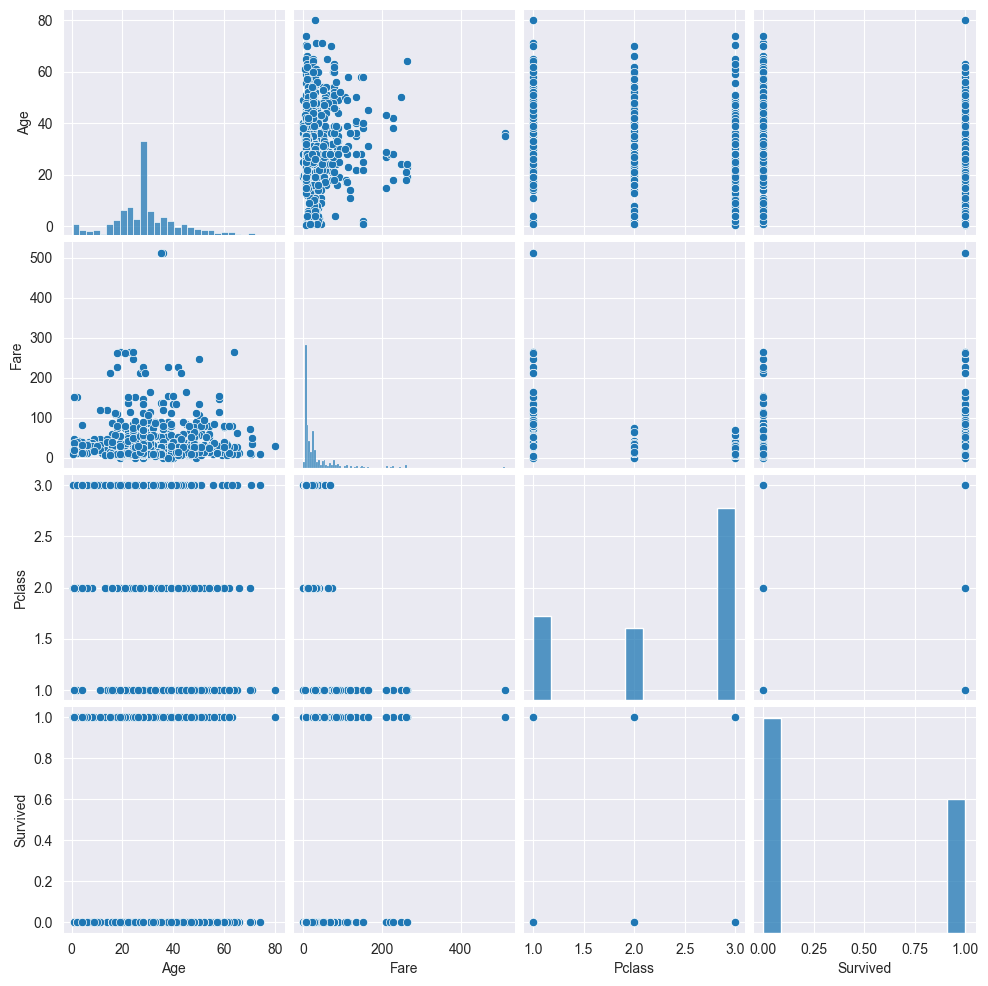

In [10]:
plot = sns.pairplot(df_filled[["Age", "Fare", "Pclass", "Survived"]])
if save_figures:
    plot.savefig("plots/pairplot.png")
plt.show()

--- Регресія ---

LinearRegression MSE: 1702.999


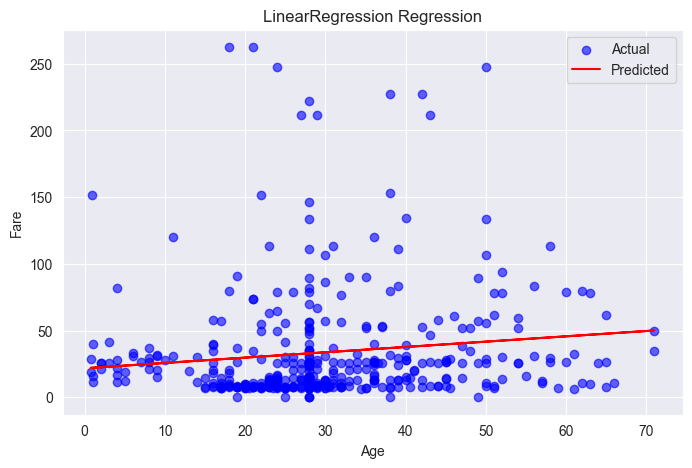

Ridge MSE: 1702.999


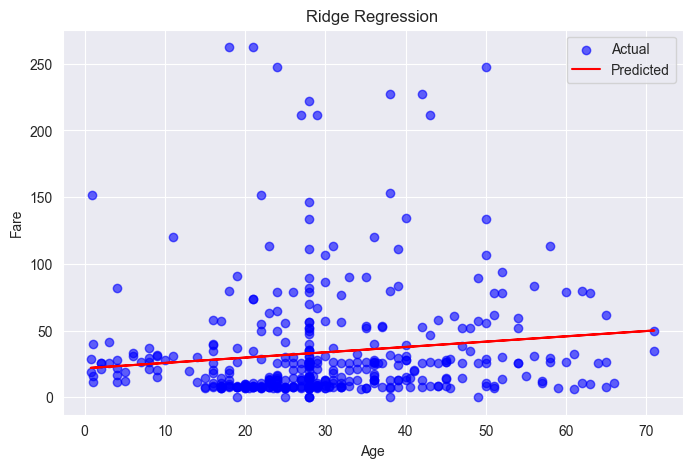

Lasso MSE: 1702.986


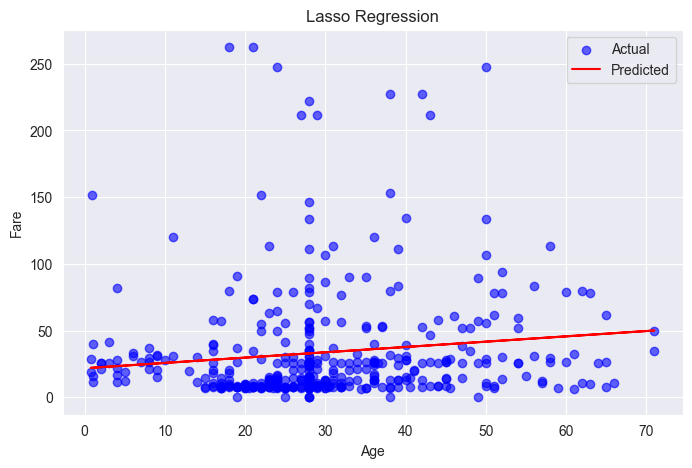

In [11]:
X = df_filled[["Age"]]
y = df_filled["Fare"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} MSE: {mse:.3f}")

    plt.figure(figsize=(8, 5))
    plt.scatter(X_test, y_test, color='blue', label='Actual', alpha=0.6)
    plt.plot(X_test, y_pred, color='red', label='Predicted')
    plt.title(f"{name} Regression")
    plt.xlabel("Age")
    plt.ylabel("Fare")
    plt.legend()
    plt.grid(True)
    if save_figures:
        plt.savefig(f"plots/regression_{name.lower()}.png")
    plt.show()

--- Мультифакторна регресія ---

In [12]:
encoder_multi = OneHotEncoder(drop='first', sparse_output=False)
categorical_cols = ['Sex', 'Embarked']
encoded_cats = encoder_multi.fit_transform(df_filled[categorical_cols])
encoded_cat_df = pd.DataFrame(encoded_cats, columns=encoder_multi.get_feature_names_out(categorical_cols))

numerical_cols = ['Age', 'Pclass', 'SibSp', 'Parch']
X_multi = pd.concat([df_filled[numerical_cols].reset_index(drop=True), encoded_cat_df], axis=1)
y_multi = df_filled['Fare']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=0.5, random_state=42)

models_multi = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}

for name, model in models_multi.items():
    model.fit(X_train_m, y_train_m)
    y_pred_m = model.predict(X_test_m)
    mse_m = mean_squared_error(y_test_m, y_pred_m)
    print(f"[Multi] {name} MSE: {mse_m:.3f}")

[Multi] LinearRegression MSE: 1023.941
[Multi] Ridge MSE: 1019.887
[Multi] Lasso MSE: 1016.610
